## Carbon predictions 
The goal is here to predict gaz emission of non-residential seattle buildings. 
Major part of the preprocessing is the same as the energy consumption, therefore we will reuse function defined in the energy prediction notebook.

Here are the different steps : 

- I. Split my data into train and test sets. Work on feature engineering  while assuring no memory leakage
- II. Fit my model hyper-parameters on the training data 
- III. Select the most appropriate model based on **R2 score** and **inference time**
- IV. Study the interpretability of the selected model
- V. **Study the relevancy of the EnergyStar score for carbon predictions **

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import shap
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  RepeatedKFold, GridSearchCV
from sklearn.metrics import  r2_score
from sklearn import dummy
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor 
from sklearn.svm import SVR
import time 
# import import_ipynb
from prediction import  getCategoricalVariables, getObjectList, getBoolList , TargetEncodingObjectlist, MinMaxNorm
from prediction import AddYearBuildTrend , TypeByGFA, getskewed_columns, BoxCoxTransform, dropBoxCoxColumns
from prediction import MinMaxNormTarget, fitLassoModel, fitKernelSVR, fitRandomForest
from prediction import getTrainingTime, getMeanExecutionTime
# fitRandomForest, 

In [2]:
# load dataset than has been clean in the cleanUp notebook 
pData = pd.read_csv('prediction.csv')

# Data split and preprocessing 


In [3]:
uData = pData.drop(columns=['ENERGYSTARScore'])
tData = uData.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions','GHGEmissionsIntensity','OSEBuildingID'])
column_sels = list(tData.columns)
X = tData.loc[:,column_sels]
X = pd.DataFrame(data=X, columns=column_sels)
Y = uData['TotalGHGEmissions']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y, 
                                                    test_size=.3, # 30% de test
                                                    random_state =123) # toujours le même spilt 

In [4]:
def Mypreprocessing(X_train, X_test, y_train,y_test,target):
    catList = getCategoricalVariables()
    objectlist = getObjectList(uData)
    boolList = getBoolList(uData)
    save_lambdas = []   
    TargetEncodingObjectlist(X_train, X_test, y_train,objectlist + catList +boolList,target)
    X_train, X_test = AddYearBuildTrend(X_train, X_test, y_train,target)
    X_train, X_test = TypeByGFA(X_train,X_test)  
    skewed_columns = getskewed_columns(X_train,0)
    X_train, X_test, _ = BoxCoxTransform(X_train, X_test,skewed_columns,save_lambdas)
    X_train, X_test = dropBoxCoxColumns(X_train,X_test, skewed_columns)
    X_train, X_test = MinMaxNorm(X_train,X_test)
    
    return X_train, X_test, y_train ,y_test  

In [5]:

X_train, X_test, y_train ,y_test  = Mypreprocessing(X_train, X_test, y_train,y_test,'TotalGHGEmissions')


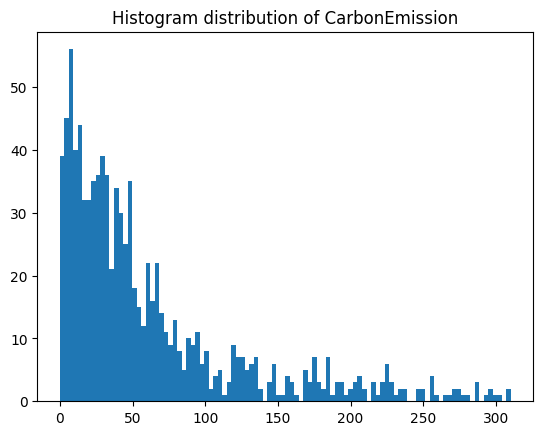

In [6]:

plt.hist(y_train, bins=100)
plt.title('Histogram distribution of CarbonEmission')
plt.show()

The target variables does not follow a normal distribution. Regression algorithms perform better with normally distributed data. Therefore we will compute a box-cox transform and a normalization on carbon emission variable. 

In [7]:
# Specific target normalization 
def CarbonEmissionTargetTransform(y_train,y_test) : 
    y_train = [ val if val > 0 else 0.0000001 for val in y_train]
    y_test = [ val if val > 0 else 0.0000001 for val in y_test]
    y_train,lam = stats.boxcox(y_train)
    y_test = stats.boxcox(y_test, lam)
    y_train = pd.Series(y_train)
    y_test = pd.Series(y_test)
    y_train,y_test = MinMaxNormTarget(y_train,y_test)
    return y_train,y_test

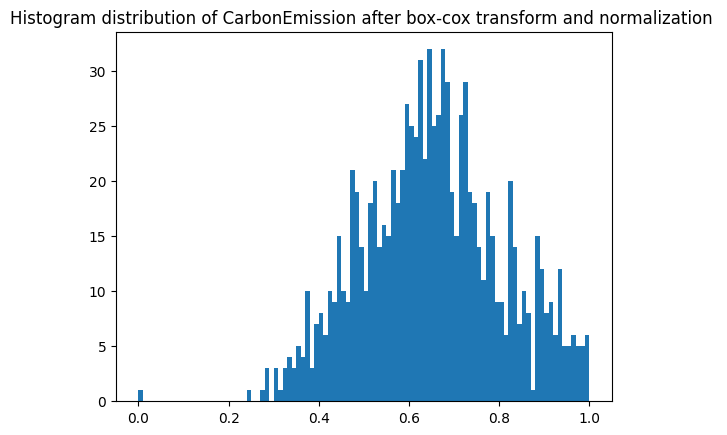

In [8]:
y_train,y_test = CarbonEmissionTargetTransform(y_train,y_test)
plt.hist(y_train, bins=100)
plt.title('Histogram distribution of CarbonEmission after box-cox transform and normalization ')
plt.show()

In [9]:
# define evaluation
cv = RepeatedKFold(n_splits=10, # number of k-folds
                n_repeats=5,
                random_state=1)# seed

train_score = {}
test_score = {}
training_time = {}
inference_time = {}

## Fitting hyper-parameters

In [10]:

LASSO_ALPHA_EM  = fitLassoModel(X_train,y_train,cv)

Best Score: 0.54054
Best Hyperparameters: {'alpha': 0.00012742749857031334}


In [11]:
KERNEL_SVR_C_EM  , KERNEL_SVR_GAMMA_EM     =  fitKernelSVR(X_train,y_train,cv)

The optimal parameters are {'C': 316.22776601683796, 'gamma': 0.001} with a score of 0.54


In [12]:
best_params =  fitRandomForest(X_train, y_train,cv) 

RF_MAX_DEPTH = best_params.get('max_depth')
RF_N  = best_params.get('n_estimators')
RF_BOOTSTRAP =  best_params.get('bootstrap')
RF_MIN_SAMPLE_LEAF =  best_params.get('bootstrap')
RF_MIN_SAMPLES_SPLIT= best_params.get('min_samples_split')

{'bootstrap': True, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100} 0.5494180734351276


## Evaluate each model with the testing set

In [13]:
from sklearn.metrics import mean_squared_error
rmse_score = {}

In [14]:
nb_test = 100 
dum = dummy.DummyRegressor(strategy='mean').fit(X_train,y_train)
train_score['dummy'] =  r2_score(y_train,dum.predict(X_train))
test_score['dummy']  = r2_score(y_test,dum.predict(X_test))

rmse_score['dummy'] = mean_squared_error(y_test,dum.predict(X_test),squared=False)


training_time['dummy'] = getTrainingTime(dum,X_train,y_train)
inference_time['dummy'] =  getMeanExecutionTime(dum,X_test,nb_test)


In [15]:
reg = LinearRegression().fit(X_train,y_train)
train_score['LinearRegression'] =  r2_score(y_train,reg.predict(X_train))
test_score['LinearRegression']  = r2_score(y_test,reg.predict(X_test))

rmse_score['LinearRegression'] = mean_squared_error(y_test,reg.predict(X_test),squared=False)


training_time['LinearRegression'] = getTrainingTime(reg,X_train,y_train)
inference_time['LinearRegression'] =  getMeanExecutionTime(reg,X_test,nb_test)


In [16]:
lasso_model = Lasso(alpha=LASSO_ALPHA_EM).fit(X_train,y_train)
train_score['Lasso']    = r2_score(y_train,lasso_model.predict(X_train))
test_score['Lasso']     = r2_score(y_test,lasso_model.predict(X_test))

rmse_score['Lasso'] = mean_squared_error(y_test,lasso_model.predict(X_test),squared=False)


training_time['Lasso'] = getTrainingTime(lasso_model,X_train,y_train)
inference_time['Lasso'] =  getMeanExecutionTime(lasso_model,X_test,nb_test)

In [17]:
svr_rbf = SVR(kernel="rbf",C= KERNEL_SVR_C_EM,gamma=KERNEL_SVR_GAMMA_EM).fit(X_train,y_train)
train_score['SVR_RBF']  = r2_score(y_train,svr_rbf.predict(X_train))
test_score['SVR_RBF']   = r2_score(y_test,svr_rbf.predict(X_test))

rmse_score['SVR_RBF'] = mean_squared_error(y_test,svr_rbf.predict(X_test),squared=False)

training_time['SVR_RBF'] = getTrainingTime(svr_rbf,X_train,y_train)
inference_time['SVR_RBF'] =  getMeanExecutionTime(svr_rbf,X_test,nb_test)

In [18]:
RF_model = RandomForestRegressor(oob_score=True,
                                 bootstrap =RF_BOOTSTRAP,
                                 min_samples_leaf=RF_MIN_SAMPLE_LEAF, 
                                 min_samples_split=RF_MIN_SAMPLES_SPLIT,
                                 n_estimators=RF_N,
                                 max_depth=RF_MAX_DEPTH).fit(X_train,y_train) # just for faster run 

train_score['RandomForest'] = r2_score(y_train,RF_model.predict(X_train))
test_score['RandomForest'] = r2_score(y_test,RF_model.predict(X_test))

rmse_score['RandomForest'] = mean_squared_error(y_test,RF_model.predict(X_test),squared=False)

training_time['RandomForest'] = getTrainingTime(RF_model,X_train,y_train)
inference_time['RandomForest'] =  getMeanExecutionTime(RF_model,X_test,nb_test)

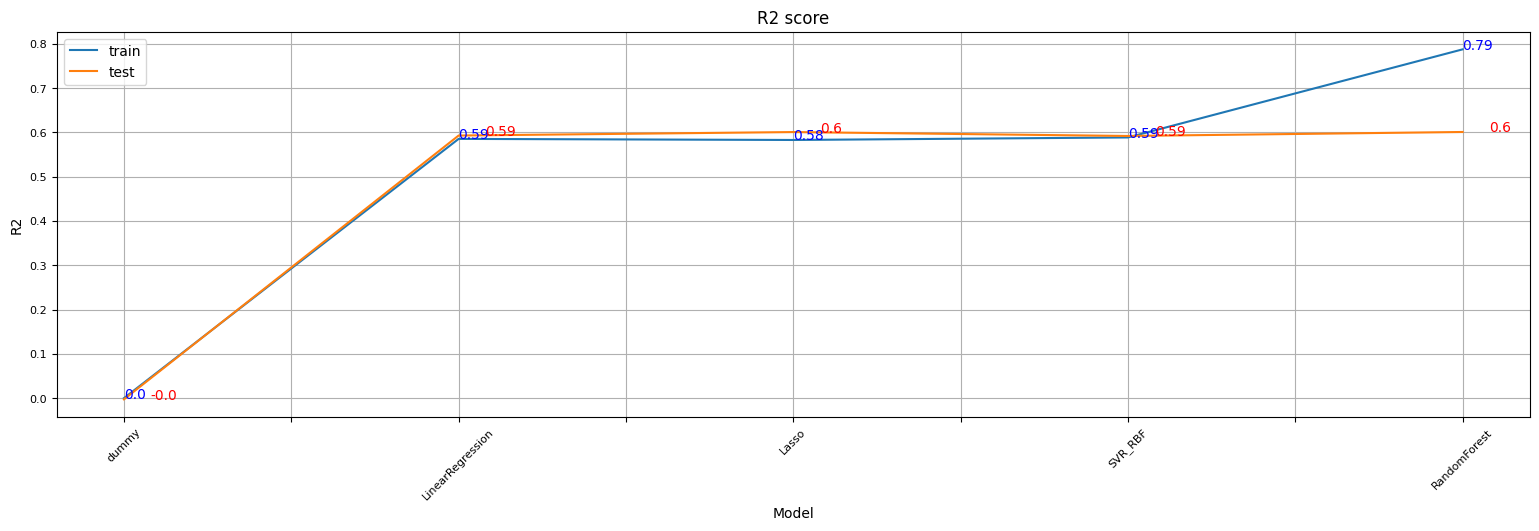

In [19]:

scores_map_train = pd.DataFrame(train_score,index=['train']).transpose()
scores_map_test = pd.DataFrame(test_score,index=['test']).transpose()
scores_map_both = scores_map_train.join(scores_map_test)
fig ,ax = plt.subplots(figsize=(19,5) )
scores_map_both.plot(ax=ax, grid=True)
rows, cols = scores_map_both.shape
offset = 0 
color='blue'
for col in range(cols):
    for i in range(rows):
        ax.annotate('{}'.format(round(scores_map_both.iloc[i, col],2)), xy=(i + offset, scores_map_both.iloc[i, col]),color =color) 
    offset = 0.08
    color='red'
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Model')
plt.ylabel("R2")
plt.title("R2 score")
plt.show()



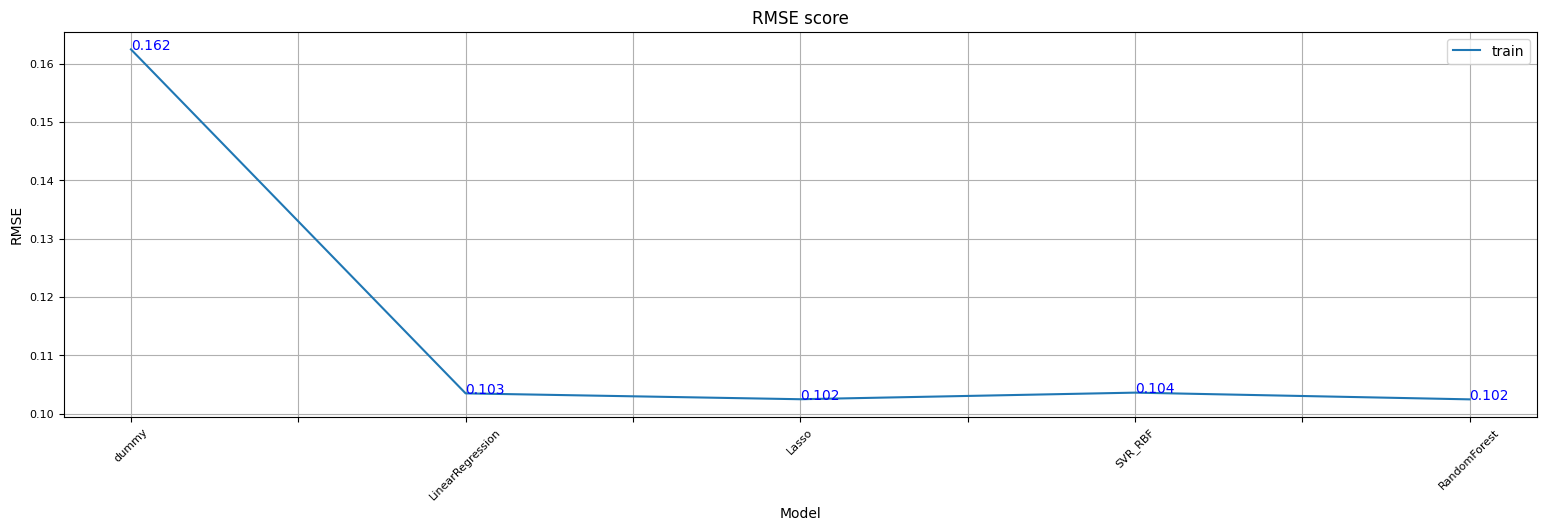

In [20]:
rmse = pd.DataFrame(rmse_score,index=['train']).transpose()
fig ,ax = plt.subplots(figsize=(19,5) )
rmse.plot(ax=ax, grid=True)
rows, cols = rmse.shape
offset = 0 
color='blue'
for col in range(cols):
    for i in range(rows):
        ax.annotate('{}'.format(round(rmse.iloc[i, col],3)), xy=(i + offset, rmse.iloc[i, col]),color =color) 
    offset = 0.15
    color='red'
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Model')
plt.ylabel("RMSE")
plt.title("RMSE score")
plt.show()

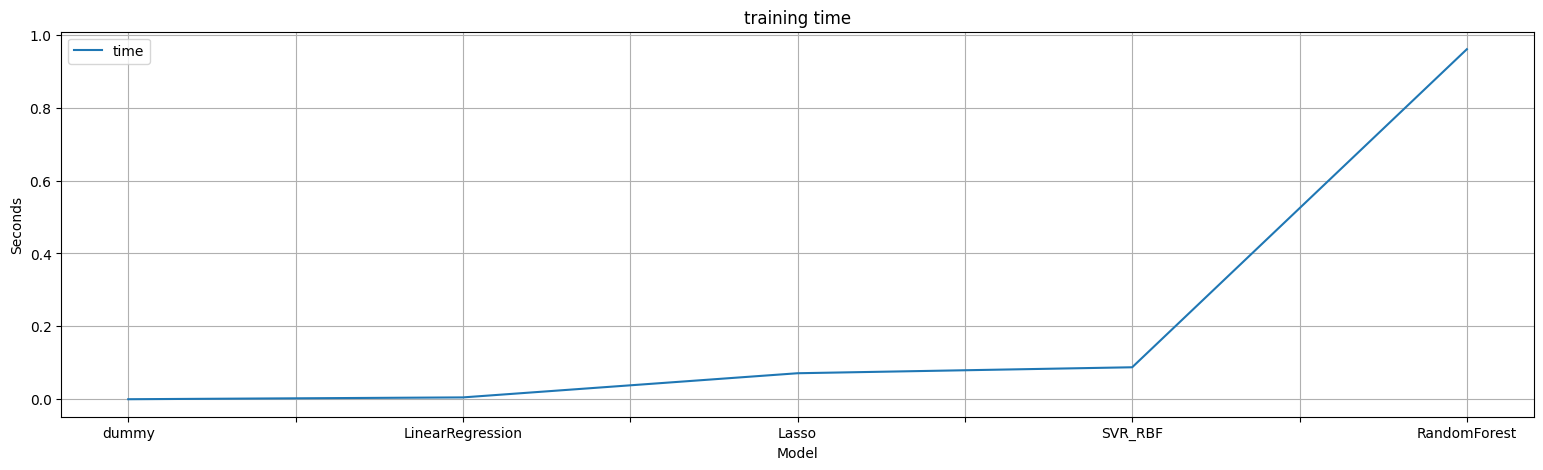

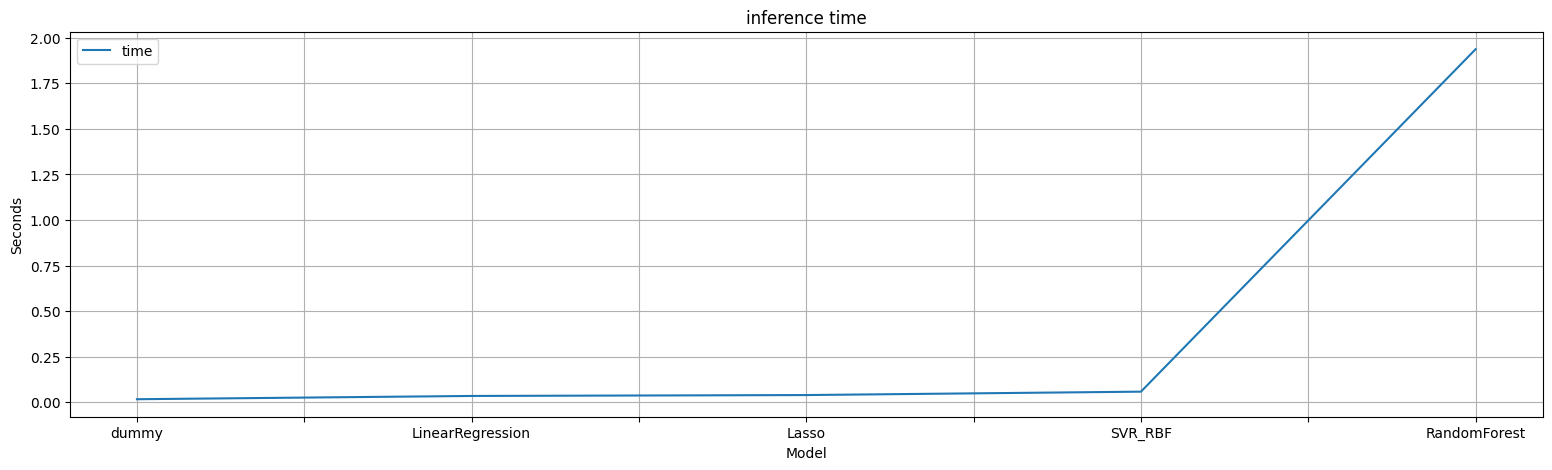

In [21]:
train_time = pd.DataFrame(training_time,index=['time']).transpose()
inf_time = pd.DataFrame(inference_time,index=['time']).transpose()
train_time.plot(figsize=(19,5) , grid=True)
plt.xlabel('Model')
plt.ylabel("Seconds")
plt.title("training time")

inf_time.plot(figsize=(19,5) , grid=True)
plt.xlabel('Model')
plt.title("inference time")
plt.ylabel("Seconds")
plt.show()


## Interpretability 


In [22]:
lasso_model = Lasso(alpha=LASSO_ALPHA_EM).fit(X_train,y_train)

Permutation explainer: 413it [00:48,  8.44it/s]                         


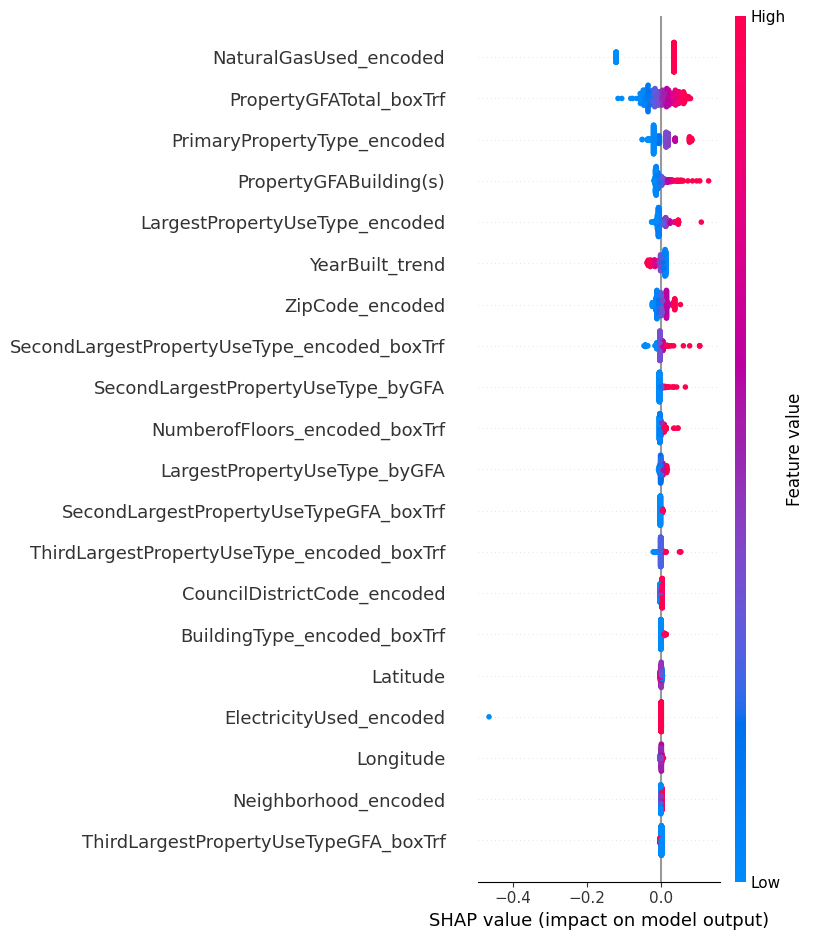

In [23]:
explainer = shap.Explainer(lasso_model.predict,X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

What is interesting here is that whether or not the building uses NaturalGas is the most important feature for carbon emission. The size of the building, like for energy consumption also matters. 

The impact of the variable core=respond to its points location, therefore the LargestPropertyUse type is associated with high prediction.
The Year of Build is more likely to contribute to the carbon emission prediction than the feature had importance in energy consumption prediction. 

## IV. Energy Star score integration 

In [24]:
esData = tData.join(pData[['ENERGYSTARScore']])

In [25]:
column_sels = list(esData.columns)
X = esData.loc[:,column_sels]
X = pd.DataFrame(data=X, columns=column_sels)
Y = uData['TotalGHGEmissions']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y, 
                                                    test_size=.3, # 30% de test
                                                    random_state =123) # toujours le même spilt 

In [26]:
X_train, X_test, y_train ,y_test  = Mypreprocessing(X_train, X_test, y_train,y_test,'TotalGHGEmissions')
y_train,y_test = CarbonEmissionTargetTransform(y_train,y_test)

In [27]:
LASSO_ALPHA_EM_STAR  = fitLassoModel(X_train,y_train,cv)

Best Score: 0.57887
Best Hyperparameters: {'alpha': 5.4555947811685143e-05}


In [28]:
lasso_model = Lasso(alpha=LASSO_ALPHA_EM_STAR).fit(X_train,y_train)
trainEnergyS = r2_score(y_train,lasso_model.predict(X_train)) 
trainpercentage = abs(trainEnergyS - train_score['Lasso'] )/ train_score['Lasso'] *100
testEnergyS = r2_score(y_test,lasso_model.predict(X_test))
testpercentage = abs(testEnergyS - test_score['Lasso'] )/ test_score['Lasso'] *100
print(f"R2 score on training set {round(trainEnergyS ,  2 ) } which correspond of an increase of {round(trainpercentage,2)} %")
print(f"R2 score on testing set {round(testEnergyS ,  2 ) } which correspond of an increase of {round(testpercentage,2)} %")

R2 score on training set 0.62 which correspond of an increase of 6.4 %
R2 score on testing set 0.64 which correspond of an increase of 5.87 %


The Energy Star improve the prediction accuracy. Therefore  it is relevant to take it into account. 